## Introdução

Esse projeto tem como objetivo prever o diagnóstico de diabetes de um paciente dado um conjunto de dados de saúde. Temos então um problema de **classificação supervisionado offline**.


## Sobre os dados


Os dados são originalmente do estudo do *National Institute of Diabetes and Digestive and Kidney Diseases* e foram discutidos [neste artigo](http://). Os dados podem ser encontrados [aqui](https://www.kaggle.com/datasets/mathchi/diabetes-data-set). Todos os dados são de pacientes mulheres de pelo menos 21 anos de idade. As *features* são:

* **Pregnancies**: Número de eventos de gravidez; 
* **Glucose**: Concentração de glicose plasmática;
* **BloodPressure**: Pressão sanguínea diastólica ($mmHg$);
* **SkinThickness**: Grossura da dobra da pele do tríceps ($mm$);
* **Insulin**: Insulina sérica ($\mu U/mL$);
* **BMI**: *Body mass index*, Peso em $kg$ / (altura em $m$)$^2$;
* **DiabetesPedigreeFunction**: mede a possibilidade de diabetes dado o histórico familiar;
* **Age**: Idade (anos);
* **Outcome**: Target, 0 para não-diabético, 1 para diabético.



## Problema de negócio e avaliação do modelo

O custo de exame e de prevenção são significativamente menores que os custos de tratamento da diabetes. Além disso, a detecção precoce facilita o tratamento (https://www.previva.com.br/reduzir-custo-do-diabetes/). Portanto nosso objetivo é desenvolver um modelo preditivo ágil, com baixa taxa de erros. Além disso, devido a recursos finitos, é importante que o modelo consiga ranquear os pacientes mais propensos para que tratamentos sejam direcionados a estes.

Durante o desenvolvimento dos modelos, utilizaremos o **AUC** como métrica. A justificativa é que um modelo com alto AUC é capaz de ter alto **recall** sem grandes perdas de **precisão**. Ao final da modelagem também analisaremos a acurácia, precisão, F1 e ROC dos modelos. Para mensurar a qualidade do ranqueamento obtido, utilizaremos métricas como **taxa do alvo**, **curva de ganhos** e **curva lift**.

Compararemos nossos resultados com um **modelo heurístico** (um modelo simples que utiliza em regras práticas intuitivas) baseado na concentração de glicose.

## Importando e explorando os dados

In [155]:
# Importando bibliotecas

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split, cross_val_score,
                                     GridSearchCV, RandomizedSearchCV, StratifiedKFold)

from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, roc_auc_score,
                             confusion_matrix, ConfusionMatrixDisplay)


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, KBinsDiscretizer, QuantileTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer

# Plotting style

plt.style.use('science')
plt.rcParams['figure.figsize'] = (7,5)
plt.rcParams['font.size'] = 16
plt.rcParams['text.usetex'] = True

In [156]:
data = pd.read_csv("../data/diabetes.csv")

In [157]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [158]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [159]:
# Checando linhas duplicadas

data.duplicated().sum()

0

In [160]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Não que seja necessário nesse caso, mas podemos reduzir o uso de memória alterando os dtypes.

In [161]:
# Reduzindo o uso de memória

int_cols = list(data.select_dtypes('int64').columns) 
float_cols = list(data.select_dtypes('float64').columns)

for col in int_cols:
    data[col] = data[col].astype('int32')
    
for col in float_cols:
    data[col] = data[col].astype('float32')

In [162]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int32  
 1   Glucose                   768 non-null    int32  
 2   BloodPressure             768 non-null    int32  
 3   SkinThickness             768 non-null    int32  
 4   Insulin                   768 non-null    int32  
 5   BMI                       768 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int32  
 8   Outcome                   768 non-null    int32  
dtypes: float32(2), int32(7)
memory usage: 27.1 KB


Tivemos uma redução significativa de uso de memória.

In [163]:
# Checando valores nulos

for col in data.columns:
    print(f"{data[col].eq(0).sum()} valores nulos ({100*data[col].eq(0).sum()/data.shape[0]:.1f} %) em {col}.")

111 valores nulos (14.5 %) em Pregnancies.
5 valores nulos (0.7 %) em Glucose.
35 valores nulos (4.6 %) em BloodPressure.
227 valores nulos (29.6 %) em SkinThickness.
374 valores nulos (48.7 %) em Insulin.
11 valores nulos (1.4 %) em BMI.
0 valores nulos (0.0 %) em DiabetesPedigreeFunction.
0 valores nulos (0.0 %) em Age.
500 valores nulos (65.1 %) em Outcome.


Valores nulos de `Glucose`, `BloodPressure`, `SkinThickness`, `Insulin` e `BMI` são na verdade dados faltantes (NaN). A coluna `Insulin` possui uma quantidade significativa de NaN.

Vamos inspecionar um pouco mais as colunas de `Glucose` e `BMI`:

In [164]:
# NaN em Glucose

data[data["Glucose"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
75,1,0,48,20,0,24.700001,0.140,22,0
182,1,0,74,20,23,27.700001,0.299,21,0
342,1,0,68,35,0,32.000000,0.389,22,0
349,5,0,80,32,0,41.000000,0.346,37,1
502,6,0,68,41,0,39.000000,0.727,41,1


In [165]:
# NaN em BMI

data[data["BMI"] == 0]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
9,8,125,96,0,0,0.0,0.232,54,1
49,7,105,0,0,0,0.0,0.305,24,0
60,2,84,0,0,0,0.0,0.304,21,0
81,2,74,0,0,0,0.0,0.102,22,0
145,0,102,75,23,0,0.0,0.572,21,0
371,0,118,64,23,89,0.0,1.731,21,0
426,0,94,0,0,0,0.0,0.256,25,0
494,3,80,0,0,0,0.0,0.174,22,0
522,6,114,0,0,0,0.0,0.189,26,0
684,5,136,82,0,0,0.0,0.640,69,0


Um número grande de instâncias que tem valor nulo em `BMI` são de pacientes não-diabéticos. Existem poucas instâncias nulas em `Glucose` e são relativamente homogêneas.

## Redifinindo dados faltantes e separação treino/teste

A partir de agora corrigiremos os valores nulos por NaN e reservaremos nosso dataset de teste para o final.

In [166]:
# Vamos substituir 0 por NaN

data_nan = data.copy()

cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in cols:
    data_nan[col] = data_nan[col].replace(0, np.nan)

data_nan.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.599998,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.600000,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.299999,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.100000,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.099998,2.288,33,1


In [167]:
data_nan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int32  
 1   Glucose                   763 non-null    float64
 2   BloodPressure             733 non-null    float64
 3   SkinThickness             541 non-null    float64
 4   Insulin                   394 non-null    float64
 5   BMI                       757 non-null    float32
 6   DiabetesPedigreeFunction  768 non-null    float32
 7   Age                       768 non-null    int32  
 8   Outcome                   768 non-null    int32  
dtypes: float32(2), float64(4), int32(3)
memory usage: 39.1 KB


In [168]:
# Separação de features e targets
X = data_nan.drop('Outcome', axis=1)
y = data_nan['Outcome']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [169]:
# Checando número de instâncias no treino e no teste e proporções

print(f'Treino: {y_train.shape[0]}')
print(f'Teste: {y_test.shape[0]}')

Treino: 537
Teste: 231


In [170]:
# Proporções dos targets no dataset completo
y.value_counts(normalize=True)

0    0.651042
1    0.348958
Name: Outcome, dtype: float64

In [171]:
# Proporções dos targets no dataset de treino
y_train.value_counts(normalize=True)

0    0.651769
1    0.348231
Name: Outcome, dtype: float64

In [172]:
# Proporções dos targets no dataset de teste
y_test.value_counts(normalize=True)

0    0.649351
1    0.350649
Name: Outcome, dtype: float64

In [173]:
# Números de instâncias por classe no teste
y_test.value_counts()

0    150
1     81
Name: Outcome, dtype: int64

## EDA (Análise exploratória de dados)

Aqui vamos plotar alguns gráficos para verificar a distribuição das varíaveis.

In [174]:
def plot_histgram_and_boxplot(data, feature):
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    sns.histplot(data=data, x=feature, hue="Outcome")

    plt.subplot(1,2,2)
    sns.boxplot(data=data, x="Outcome", y=feature)
    
    plt.suptitle(feature)
    plt.show()

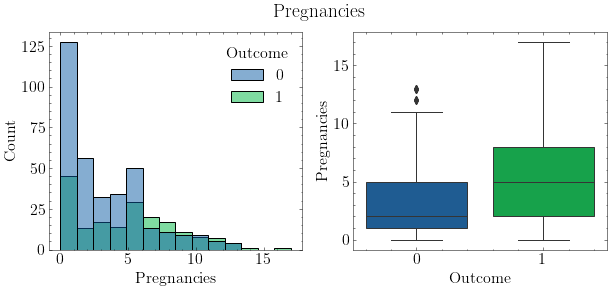

In [175]:
plot_histgram_and_boxplot(X_train.join(y_train), "Pregnancies")

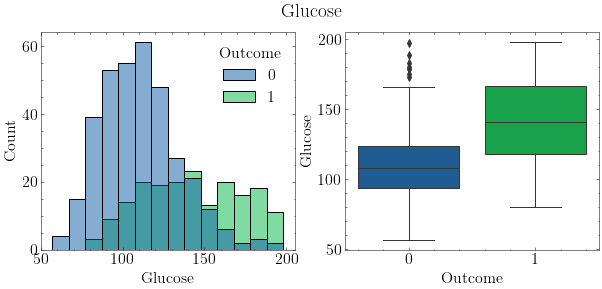

In [176]:
plot_histgram_and_boxplot(X_train.join(y_train), "Glucose")

In [177]:
# Algumas métricas de Glucose separadas por Outcome

X_train.join(y_train).loc[:, ['Outcome', 'Glucose']].groupby('Outcome').describe()

Glucose                                                           
          count        mean        std   min     25%    50%     75%    max
Outcome                                                                   
0         348.0  110.652299  23.818413  57.0   93.75  108.0  124.00  197.0
1         186.0  142.053763  29.810524  80.0  118.00  141.0  166.75  198.0

As médias são razoavelmente diferentes, mas os desvios são relativamentos próximos.

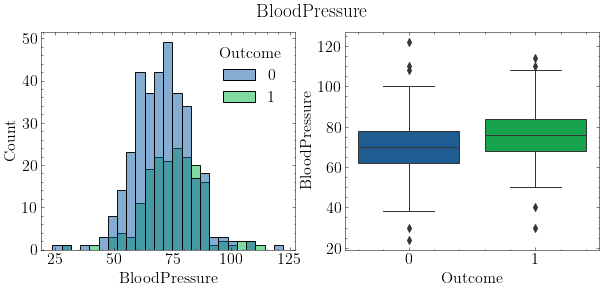

In [178]:
plot_histgram_and_boxplot(X_train.join(y_train), "BloodPressure")

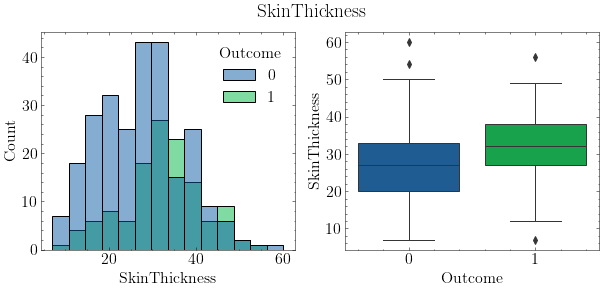

In [179]:
plot_histgram_and_boxplot(X_train.join(y_train), "SkinThickness")

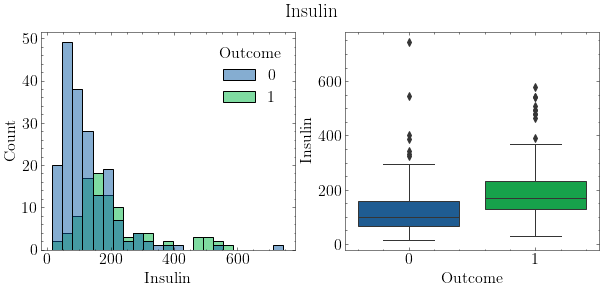

In [180]:
plot_histgram_and_boxplot(X_train.join(y_train), "Insulin")

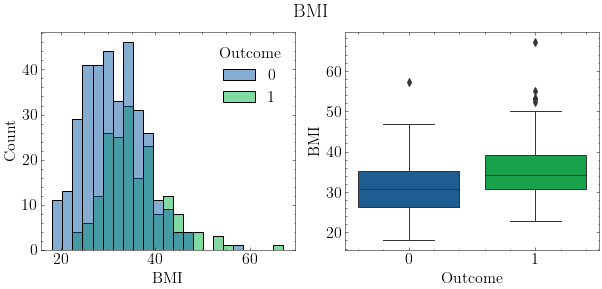

In [181]:
plot_histgram_and_boxplot(X_train.join(y_train), "BMI")

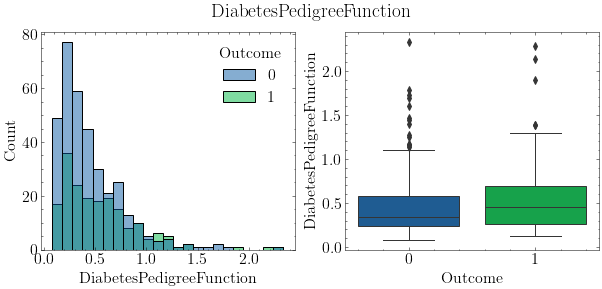

In [182]:
plot_histgram_and_boxplot(X_train.join(y_train), "DiabetesPedigreeFunction")

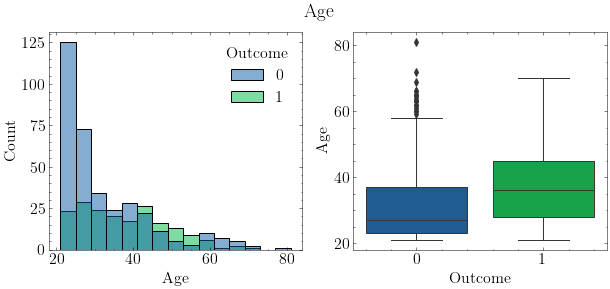

In [183]:
plot_histgram_and_boxplot(X_train.join(y_train), "Age")

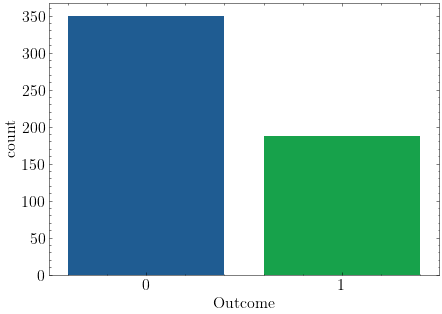

In [184]:
sns.countplot(data=X_train.join(y_train),  x='Outcome');

Faremos o teste **correlação de Spearman** entre as features e os targets já que temos features numéricas e o target categórico. Entre as features, podemos verificar a **correlação de Pearson** já que são todas numéricas.

In [185]:
def correlacao(data):
    """
    Calcula coefiente de correlação (Spearman) das features com o target.
    """
    corr_matrix = data.corr(method='spearman')
    print(corr_matrix["Outcome"].sort_values(ascending=False))  

In [186]:
correlacao(X_train.join(y_train))

Outcome                     1.000000
Glucose                     0.477206
Insulin                     0.408592
BMI                         0.306924
Age                         0.291502
SkinThickness               0.253378
Pregnancies                 0.207352
BloodPressure               0.188599
DiabetesPedigreeFunction    0.153839
Name: Outcome, dtype: float64


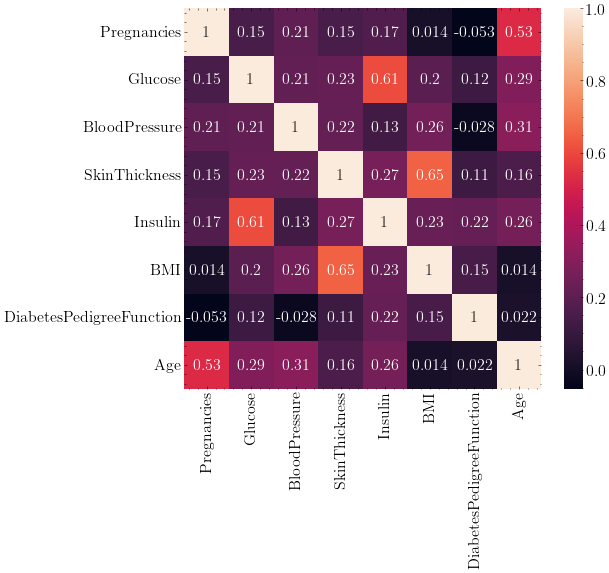

In [187]:
# Correlação (Pearson) entre todas as features

plt.figure(figsize=(8,7))
sns.heatmap(data=X_train.corr(), annot=True);

A partir da EDA podemos concluir que nossa *target* `Outcome`  pode se beneficiar de algumas técnicas para dados desbalanceados, e é bem correlacionada com `Glucose`, `Insulin`, `BMI` e `Age`. Entretanto, parece já existir uma dependência entre `Age` e `Preganancies`. Também parece haver algum grau de codepêndencia entre `SkinThickness` e `BMI`, e entre `Insulin` e `Glucose`.

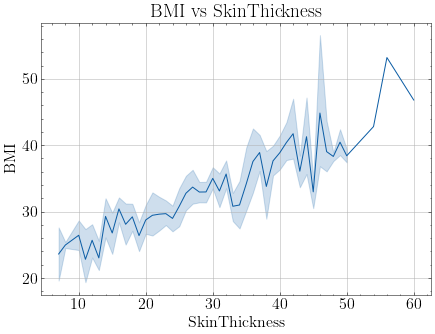

In [188]:
sns.lineplot(data=X_train, x='SkinThickness', y='BMI')
plt.title("BMI vs SkinThickness")
plt.grid()
plt.show()

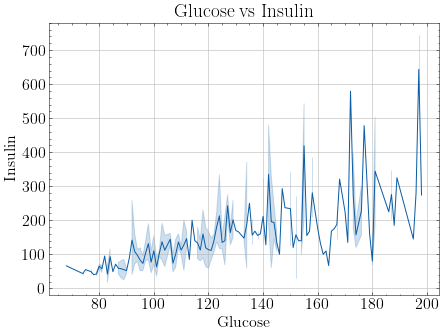

In [189]:
sns.lineplot(data=X_train, x='Glucose', y='Insulin')
plt.title("Glucose vs Insulin")
plt.grid()
plt.show()

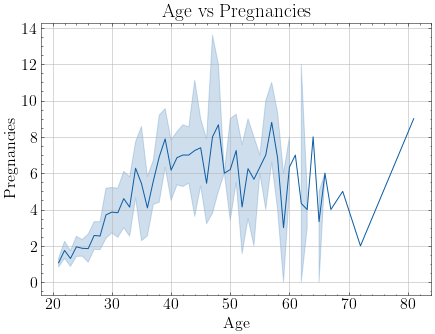

In [190]:
sns.lineplot(data=X_train, x='Age', y='Pregnancies')
plt.title("Age vs Pregnancies")
plt.grid()
plt.show()

Podemos também checar visualmente a separabilidade do nosso target com t-SNE.

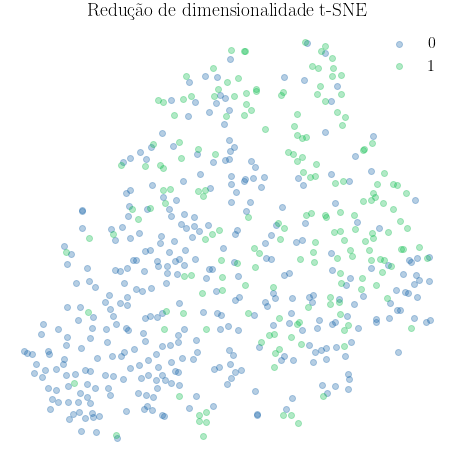

In [191]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
imp = SimpleImputer(strategy='mean')
std = StandardScaler()

tsne_pipeline = Pipeline([('imputer', imp), ('scaler', std),('tsne', tsne)])

X_train_tsne = tsne_pipeline.fit_transform(X_train)

plt.figure(figsize=(8,8))
plt.scatter(X_train_tsne[y_train == 0,0], X_train_tsne[y_train == 0,1], alpha=0.3, label='0')
plt.scatter(X_train_tsne[y_train == 1,0], X_train_tsne[y_train == 1,1], alpha=0.3, label='1')
plt.legend()
plt.title('Redução de dimensionalidade t-SNE')
plt.axis('off')
plt.show()

Reduzindo para duas dimensões, é possível notar visualmente que os dados tem alguma separabilidade.

## Modelo de referência

Nosso modelo heurístico é baseado no fato que a taxa de glicose deve ser o parâmetro mais importante para determinar se um paciente é diabético. Dito isto, vamos tentar achar um valor ideal de `Glucose` que nos dê a melhor acurácia.

In [192]:
# Criar um X, y para modelo de referência, dropando os NaNs

filtro_nan = X_train['Glucose'].isna()
index_nan = X_train[filtro_nan].index.tolist()

X_train_heuristic = X_train[['Glucose']].drop(index=index_nan)
y_train_heuristic = y_train.drop(index=index_nan)

In [193]:
# Treinando o modelo

glucose_thr = np.arange(62, 198, 1)
accuracy_list = []
recall_list = []
precision_list = []
f1_list = []

def test_glucose(gl, thr):
    if gl >= thr:
        return 1
    else:
        return 0
    
for thr in glucose_thr:
    outcome_predict = X_train_heuristic["Glucose"].apply(test_glucose, thr=thr)
    
    accuracy = np.round(accuracy_score(y_train_heuristic, outcome_predict), 4)
    precision = np.round(precision_score(y_train_heuristic, outcome_predict), 4)
    recall = np.round(recall_score(y_train_heuristic, outcome_predict), 4)
    f1 = np.round(f1_score(y_train_heuristic, outcome_predict), 4)
    
    accuracy_list.append(accuracy)
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

Utilizaremos o cruzamento entre precision e recall: ainda conservamos um bom recall, temos um alguma precisão e estamos um bom ponto de acurácia.

In [194]:
# Encontrando o ponto de acurácia máxima

accuracy_array = np.array(accuracy_list)
idx = accuracy_array.argmax()

train_recall = recall_list[idx]
train_precision = precision_list[idx]
train_accuracy = accuracy_list[idx]
train_f1 = f1_list[idx]

thr_heuristic = glucose_thr[idx]

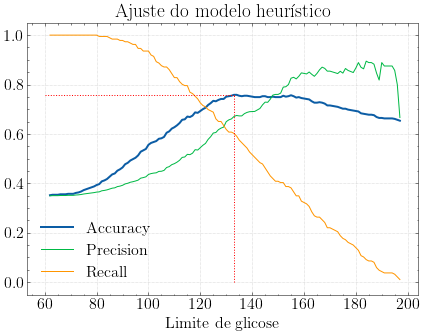

In [195]:
plt.plot(glucose_thr, accuracy_list, label='Accuracy', linewidth=2)
plt.plot(glucose_thr, precision_list, label='Precision')
plt.plot(glucose_thr, recall_list, label='Recall')
# plt.plot(glucose_thr, f1_list, label='F1')
plt.hlines(y=train_accuracy, xmin=60, xmax=thr_heuristic, linestyle=':', linewidth=1, color='r')
plt.vlines(x=thr_heuristic, ymin=0.0, ymax=train_accuracy, linestyle=':', linewidth=1, color='r')
plt.xlabel("Limite de glicose")
plt.legend()
plt.grid(ls=":")
plt.title("Ajuste do modelo heurístico")
plt.show()

In [196]:
# Print das métricas de treino

print("Métricas de treino:")
print(f"Acurácia: {train_accuracy}")
print(f"Precisão: {train_precision}")
print(f"Recall: {train_recall}")
print(f"F1: {train_f1}")

Métricas de treino:
Acurácia: 0.7584
Precisão: 0.6707
Recall: 0.6022
F1: 0.6346


Finalmente, vamos avaliar o modelo com os dados de teste. Essas métricas serão uma das nossas referências para avaliar a performace no final.

In [197]:
# Removendo NaN do teste

filtro_nan = X_test['Glucose'].isna()
index_nan = X_test[filtro_nan].index.tolist()

X_test_heuristic = X_test[['Glucose']].drop(index=index_nan)
y_test_heuristic = y_test.drop(index=index_nan)

In [198]:
# Predict no dataset de teste

outcome_predict = X_test_heuristic["Glucose"].apply(test_glucose, thr=thr_heuristic)

accuracy = np.round(accuracy_score(y_test_heuristic, outcome_predict), 4)
precision = np.round(precision_score(y_test_heuristic, outcome_predict), 4)
recall = np.round(recall_score(y_test_heuristic, outcome_predict), 4)
f1 = np.round(f1_score(y_test_heuristic, outcome_predict), 4)

print("Métricas de teste:")
print(f"Acurácia: {accuracy}")
print(f"Precisão: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Métricas de teste:
Acurácia: 0.6943
Precisão: 0.5676
Recall: 0.525
F1: 0.5455


Ao final também iremos comparar a matriz de confusão:

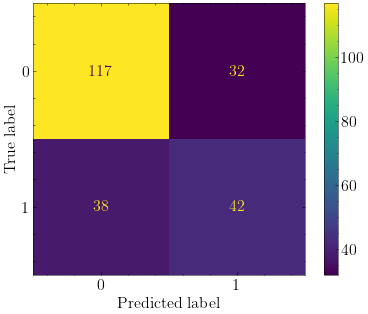

In [199]:
# Matriz de confusão para o modelo heurístico

cm_heuristic = confusion_matrix(y_test_heuristic, outcome_predict)
ConfusionMatrixDisplay(cm_heuristic).plot();

Naturalmente a acurácia é menor com os dados de teste, mas o recall desse modelo é significativamente baixo. Em particular tivemos um grande número de **falsos negativos**: pacientes que eram diabéticos mas que receberam diagnóstico negativo. Esse tipo de erro causa muito impacto nos custos de tratamento.

# Baseline ML

Começaremos aqui a construir um modelo simples de machine learning que sirva de baseline. Faremos o mínimo tratamento dos dados ou otimizações nos modelos no momento. Utilizaremos **validação cruzada estratificada** uma vez que temos poucas instâncias no dataset e reservaremos o dataset de teste para a avaliação final.

In [200]:
def validacao_cruzada(X, y, estimator, cv=5, return_estimator=False, treatment=None, balancer=None):
    """
    Validação cruzada de n-folds, estratificada. Retorna médias da acurácia, precisão e recall.
    Retorna estimador de acordo com a flag return_estimator.
    Se houver balancer, faz balanceamento das classes.
    """

    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    auc_array = np.zeros(cv)
    accuracy_array = np.zeros(cv)
    precision_array = np.zeros(cv)
    recall_array = np.zeros(cv)

    for i, (train_index, validation_index) in enumerate(skf.split(X, y)):
        # Split        
        X_train_split = X.iloc[train_index]
        y_train_split = y.iloc[train_index]
        
        X_val_split = X.iloc[validation_index]
        y_val_split = y.iloc[validation_index]

        # Tratamento
        if treatment:
            X_train_split = treatment.fit_transform(X_train_split, y_train_split)
            X_val_split = treatment.fit_transform(X_val_split, y_val_split)
        
        # Balanceamento
        
        if balancer:
            X_train_split, y_train_split = balancer.fit_resample(X_train_split, y_train_split)

        # Fit e predict
        estimator.fit(X_train_split, y_train_split)
        y_pred = estimator.predict(X_val_split)
        y_scores = estimator.predict_proba(X_val_split)[:,1]

        # Scoring

        auc_array[i] = roc_auc_score(y_val_split, y_scores)
        accuracy_array[i] = accuracy_score(y_val_split, y_pred)
        precision_array[i] = precision_score(y_val_split, y_pred)
        recall_array[i] = recall_score(y_val_split, y_pred)
        
        
    # Priting results
    print(f'Modelo {estimator}')
    print(f'ROC-AUC: {auc_array.mean()} (std={auc_array.std()})')
    print(f'Acurácia: {accuracy_array.mean()} (std={accuracy_array.std()})')
    print(f'Precisão: {precision_array.mean()} (std={precision_array.std()})')
    print(f'Recall: {recall_array.mean()} (std={recall_array.std()})')
    
    if return_estimator:
        if treatment:
            X = treatment.fit_transform(X, y)
        
        if balancer:
            X, y = balancer.fit_resample(X, y)
            
        estimator.fit(X, y)
        return estimator

### Decision Tree

Começaremos com uma **decision tree** para ganhar algum insight sobre os dados:

In [201]:
# Decision Tree

imp = SimpleImputer(strategy='constant', fill_value=0)
tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

tree_clf = validacao_cruzada(X_train, y_train, tree_clf, return_estimator=True, treatment=imp)

Modelo DecisionTreeClassifier(max_depth=2, random_state=42)
ROC-AUC: 0.7691861410282462 (std=0.035975993560569984)
Acurácia: 0.7467462789892696 (std=0.014770672745993956)
Precisão: 0.6896303441889181 (std=0.08044744958208114)
Recall: 0.5406827880512092 (std=0.09529564073659845)


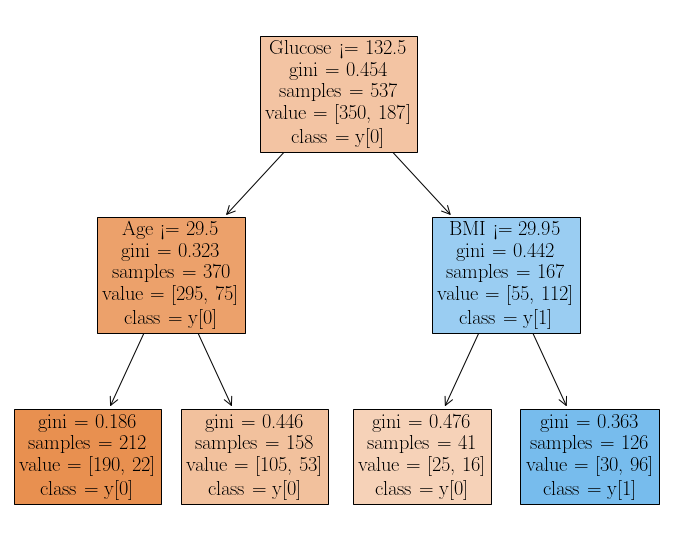

In [202]:
# Plotando árvore

fig = plt.figure(figsize=(12,10))
_ = tree.plot_tree(tree_clf, 
                   feature_names=X_train.columns,  
                   class_names=True,
                   filled=True)

Mesmo com uma árvore simples, já temos uma acurácia razoável. Também confirmamos a expectativa de que `Glucose` é uma variável importante nesse problema.

### Logistic Regression

Também podemos treinar uma **regressão logística**, já que nem todas as features entraram na decision tree. Nesse caso, precisamos normalizar os dados.

In [203]:
# Logistic Regression

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression()

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression()
ROC-AUC: 0.8232473074578339 (std=0.03910121906772699)
Acurácia: 0.7933887158186224 (std=0.03438486777619503)
Precisão: 0.7589809299895507 (std=0.06474296550649572)
Recall: 0.5997155049786629 (std=0.06888569780654102)


### Random Forest

In [204]:
# Random Forest

imp = SimpleImputer(strategy='constant', fill_value=0)
forest_clf = RandomForestClassifier(random_state=42)

forest_clf = validacao_cruzada(X_train, y_train, forest_clf, treatment=imp, return_estimator=True)

Modelo RandomForestClassifier(random_state=42)
ROC-AUC: 0.8087096118675067 (std=0.041403203187841464)
Acurácia: 0.7673589477327795 (std=0.03586709973984574)
Precisão: 0.704531490015361 (std=0.07086149873148931)
Recall: 0.588620199146515 (std=0.09250748360563006)


A partir da floresta treinada podemos extrair a importância de cada feature.

In [205]:
feature_importance = pd.DataFrame(zip(X_train.columns, forest_clf.feature_importances_),
                                  columns=['feature', 'importance']).sort_values(by='importance', 
                                                                                 ascending=False).reset_index(drop=True)
feature_importance

,feature,importance
0,Glucose,0.272161
1,BMI,0.151320
2,Age,0.129989
3,DiabetesPedigreeFunction,0.118306
4,Pregnancies,0.096944
5,BloodPressure,0.089079
6,Insulin,0.073077
7,SkinThickness,0.069124


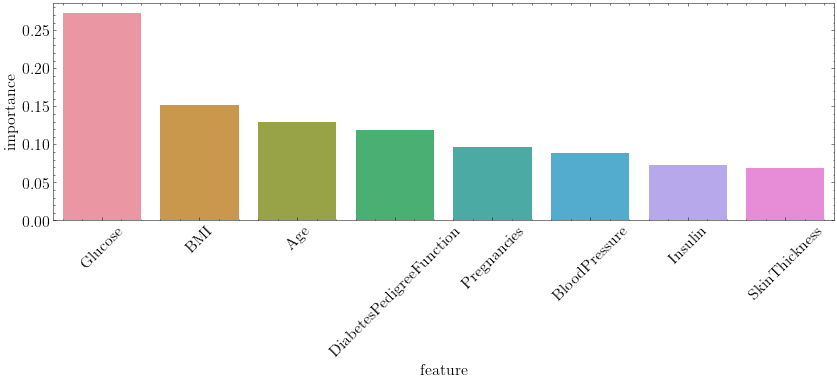

In [206]:
plt.figure(figsize=(14,4))
chart = sns.barplot(data=feature_importance, x='feature', y='importance')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

Confirmamos que `Glucose`, `BMI` e `Age` são variáveis importantes.

### Support Vector Machine

In [207]:
# Logistic Regression

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
svm_clf = SVC(kernel='linear', probability=True)

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, svm_clf, treatment=tr_pipeline)

Modelo SVC(kernel='linear', probability=True)
ROC-AUC: 0.8240073155862631 (std=0.03786647044074964)
Acurácia: 0.789650398061613 (std=0.027314765125262565)
Precisão: 0.7570833333333333 (std=0.05897857426406835)
Recall: 0.5889046941678521 (std=0.0520478179420909)


Com esses modelos simples de ML já temos resultados significativamente melhores que o modelo heurístico.

# Tratamento dos dados

## Balanceamento das classes

Vamos testar três métodos de balanceamento: **class_weight**, **undersampling** e **oversampling**.

In [208]:
# Sem balanceamento

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression()

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression()
ROC-AUC: 0.8232473074578339 (std=0.03910121906772699)
Acurácia: 0.7933887158186224 (std=0.03438486777619503)
Precisão: 0.7589809299895507 (std=0.06474296550649572)
Recall: 0.5997155049786629 (std=0.06888569780654102)


In [209]:
# Usando class_weight balanced

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight='balanced')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight='balanced')
ROC-AUC: 0.8228104043893518 (std=0.03940619900639488)
Acurácia: 0.7449463482173763 (std=0.018211532099481727)
Precisão: 0.613586479303408 (std=0.017371703669115675)
Recall: 0.7223328591749645 (std=0.05252305138387073)


In [210]:
# Usando class_weight dando importance de 1.6 maior para classe 1

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8235724446250762 (std=0.039419049667441)
Acurácia: 0.7561613014884043 (std=0.026851805837320025)
Precisão: 0.6417969564311028 (std=0.026876418684377134)
Recall: 0.6745376955903272 (std=0.0644831673343219)


Em geral usar pesos com o parâmetro `class_weight` implica no **tradeoff recall-precision**. Houve pouca variação no AUC A opção *balanced* reduz bastante a precisão dos dados. Portanto, talvez o um parâmetro intermediário de 1.6 seja mais interessante. Podemos voltar a ajustar esse parâmetro no futuro.

In [211]:
# Undersampling

from imblearn.under_sampling import NearMiss

nm = NearMiss(sampling_strategy=0.6, n_neighbors=3)

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline, balancer=nm)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8215850436903068 (std=0.037506300858086976)
Acurácia: 0.74312911041883 (std=0.028762674592773294)
Precisão: 0.6095697932236022 (std=0.02911449768073707)
Recall: 0.7278805120910384 (std=0.05906201607142035)


In [212]:
# Oversampling

from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.55, random_state=42)

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight='balanced')

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline, balancer=smote)

Modelo LogisticRegression(class_weight='balanced')
ROC-AUC: 0.8222170290591343 (std=0.04087735716951745)
Acurácia: 0.7449463482173763 (std=0.018211532099481727)
Precisão: 0.613586479303408 (std=0.017371703669115675)
Recall: 0.7223328591749645 (std=0.05252305138387073)


Ambos os tratamentos com NearMiss e SMOTE se mostraram pouco efetivos comparados com o ajuste do class_weight. Seguiremos apenas com esse último.

### Lidando com dados faltantes

Vamos comparar o SimpleImputer (testando média e mediana) e o KNNImputer.

In [213]:
# Último resultado como referência. Sem tratamento de NaN

imp = SimpleImputer(strategy='constant', fill_value=0)
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8235724446250762 (std=0.039419049667441)
Acurácia: 0.7561613014884043 (std=0.026851805837320025)
Precisão: 0.6417969564311028 (std=0.026876418684377134)
Recall: 0.6745376955903272 (std=0.0644831673343219)


In [214]:
# Simple imputer com mean

imp = SimpleImputer(strategy='mean')
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8376773013615118 (std=0.03175423710057013)
Acurácia: 0.7766008999653861 (std=0.02368260288948402)
Precisão: 0.6643109360069087 (std=0.0217992954596213)
Recall: 0.7226173541963016 (std=0.06584692428323317)


In [215]:
# Simple imputer com median

imp = SimpleImputer(strategy='median')
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8375289575289575 (std=0.032105657705070276)
Acurácia: 0.7747490481135341 (std=0.029138989185656963)
Precisão: 0.661280117326629 (std=0.031788652431073004)
Recall: 0.7226173541963016 (std=0.06584692428323317)


In [216]:
# Testando KNNImputer

imp = KNNImputer(n_neighbors=13)
std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('scaler', std)])

validacao_cruzada(X_train, y_train, log_clf, treatment=tr_pipeline)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.838230034545824 (std=0.03400710253915108)
Acurácia: 0.7710453444098305 (std=0.029029533473122204)
Precisão: 0.6590796755498072 (std=0.030292937486176934)
Recall: 0.7066856330014224 (std=0.07010161688103839)


Vamos usar o tratamento do `KNNImputer` com a `n_neighbors=13`. Antes de prosseguir vamos analisar novamente os dados após o tratamento.

In [217]:
# Reconstruindo o dataframe

X_train_impute = tr_pipeline.fit_transform(X_train)

X_train_impute = pd.DataFrame(tr_pipeline['scaler'].inverse_transform(X_train_impute), 
                              columns=X_train.columns, 
                              index=X_train.index)

X_train_impute.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
209,7.0,184.0,84.0,33.000000,242.307692,35.500000,0.355,41.0
176,6.0,85.0,78.0,28.384615,89.538462,31.200001,0.382,42.0
147,2.0,106.0,64.0,35.000000,119.000000,30.500000,1.400,34.0
454,2.0,100.0,54.0,28.000000,105.000000,37.799999,0.498,24.0
636,5.0,104.0,74.0,31.615385,137.538462,28.799999,0.153,48.0


Podemos agora verificar as distribuições após o impute.

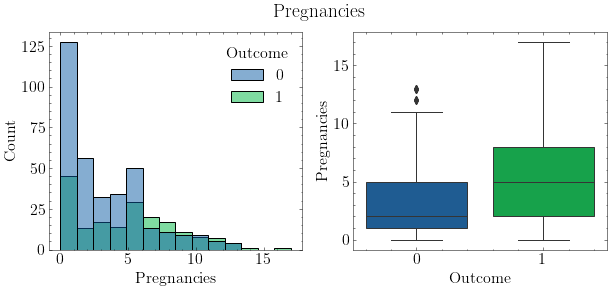

In [218]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Pregnancies")

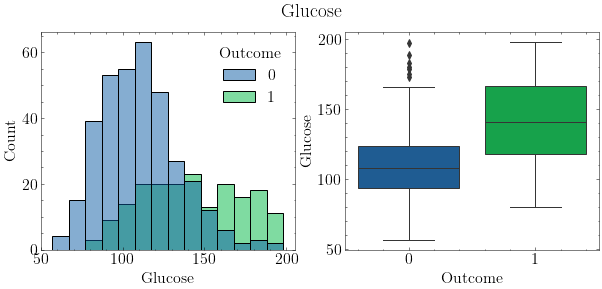

In [219]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Glucose")

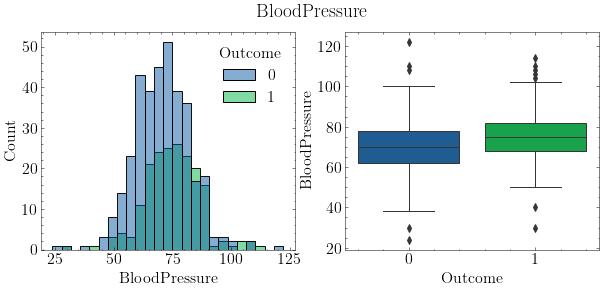

In [220]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BloodPressure")

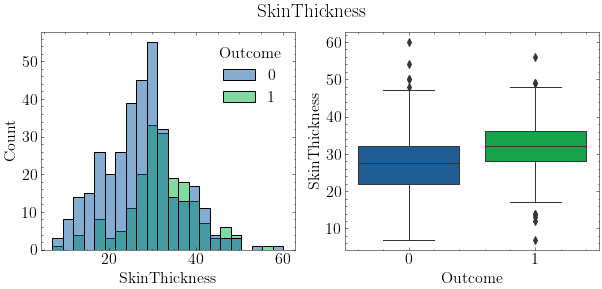

In [221]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "SkinThickness")

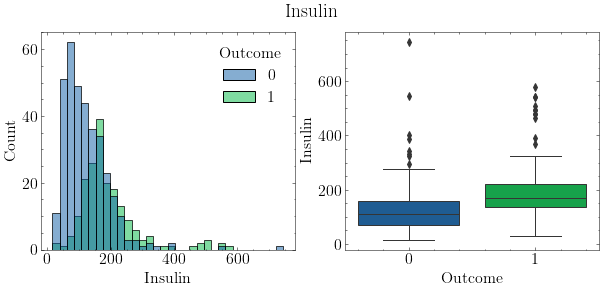

In [222]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Insulin")

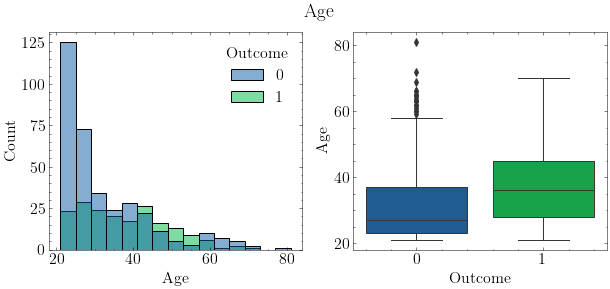

In [223]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "Age")

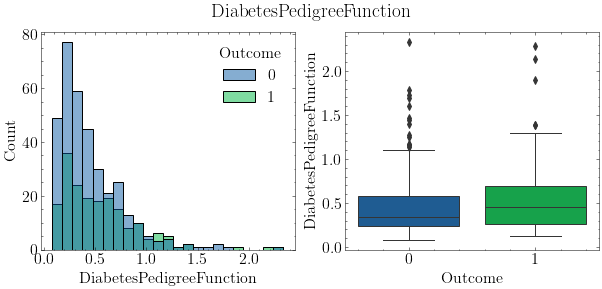

In [224]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "DiabetesPedigreeFunction")

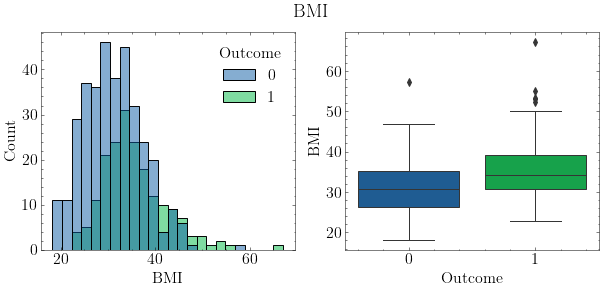

In [225]:
plot_histgram_and_boxplot(X_train_impute.join(y_train), "BMI")

Vamos verificar novamente a matriz de correlação.

In [226]:
corr_matrix = X_train_impute.join(y_train).corr()
print(corr_matrix["Outcome"].sort_values(ascending=False))

Outcome                     1.000000
Glucose                     0.498358
Insulin                     0.372824
BMI                         0.318004
SkinThickness               0.259204
Pregnancies                 0.231165
Age                         0.229853
BloodPressure               0.173921
DiabetesPedigreeFunction    0.144583
Name: Outcome, dtype: float64


As distribuições se mantiveram sem muitas distorções. Nota-se que em algumas features temos uma melhor correlação de diversas features com o target.

### Log transformation

A distribuição da `DiabetesPedigreeFunction` e `Insulin `parecem muito inviesadas. Aplicar um logaritmo pode ajudar a torna-las mais normais, o que ajuda nossos modelos:

In [227]:
imp = KNNImputer(n_neighbors=13)
log_transform = FunctionTransformer(np.log, feature_names_out='one-to-one')
ct = ColumnTransformer([('log_transform', log_transform, ['Insulin', 'DiabetesPedigreeFunction'])],
                        remainder='passthrough')

std = StandardScaler()
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

tr_pipeline = Pipeline([('imputer', imp), ('ct', ct)]).set_output(transform='pandas')

X_train_log = tr_pipeline.fit_transform(X_train)

In [228]:
X_train_log.head()

,log_transform__Insulin,log_transform__DiabetesPedigreeFunction,remainder__Pregnancies,remainder__Glucose,remainder__BloodPressure,remainder__SkinThickness,remainder__BMI,remainder__Age
209,5.490208,-1.035638,7.0,184.0,84.0,33.000000,35.500000,41.0
176,4.494668,-0.962335,6.0,85.0,78.0,28.384615,31.200001,42.0
147,4.779123,0.336472,2.0,106.0,64.0,35.000000,30.500000,34.0
454,4.653960,-0.697155,2.0,100.0,54.0,28.000000,37.799999,24.0
636,4.923904,-1.877317,5.0,104.0,74.0,31.615385,28.799999,48.0


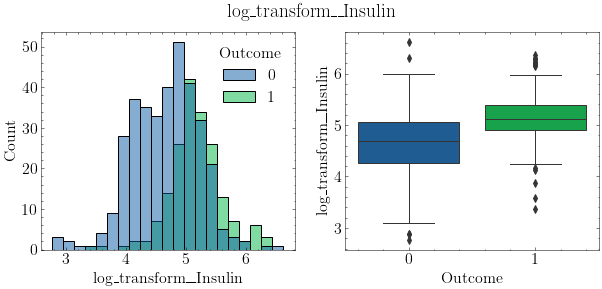

In [229]:
plot_histgram_and_boxplot(X_train_log.join(y_train), "log_transform__Insulin")

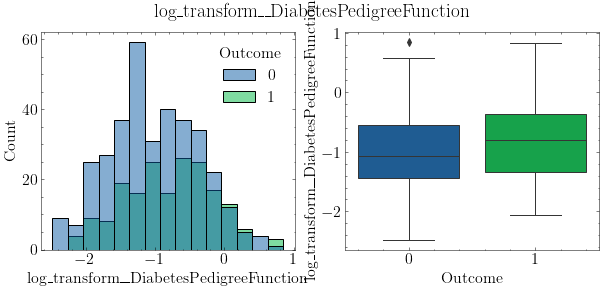

In [230]:
plot_histgram_and_boxplot(X_train_log.join(y_train), "log_transform__DiabetesPedigreeFunction")

In [231]:
correlacao(X_train_log.join(y_train))

Outcome                                    1.000000
remainder__Glucose                         0.477387
log_transform__Insulin                     0.431625
remainder__BMI                             0.306815
remainder__Age                             0.291502
remainder__SkinThickness                   0.284747
remainder__Pregnancies                     0.207352
remainder__BloodPressure                   0.183750
log_transform__DiabetesPedigreeFunction    0.153839
Name: Outcome, dtype: float64


As distribuições parecem mais normais e as correlações melhoraram.

In [232]:
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

validacao_cruzada(X_train_log, y_train, log_clf, treatment=std)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8410404389351758 (std=0.03366313001124223)
Acurácia: 0.7728798892350294 (std=0.02095134062839893)
Precisão: 0.661024531024531 (std=0.017404021201498383)
Recall: 0.7119487908961594 (std=0.06716734052209614)


Melhoramos nosso AUC. Ótimo.

### Binning

Vamos tentar agora agrupar dados para reduzir o ruído de alguma feature. Como discutido, fazer esse tratamento isso na `Age` talvez ajude nosso modelo. 

Usaremos `KBinsDiscretizer`:

In [233]:
# KBins

imp = KNNImputer(n_neighbors=13)
log_transform = FunctionTransformer(np.log, feature_names_out='one-to-one')
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

ct = ColumnTransformer([('log_transform', log_transform, ['Insulin', 'DiabetesPedigreeFunction']),
                        ('kbins', kbins, ['Age'])
                       ], remainder='passthrough')


tr_pipeline = Pipeline([('imputer', imp), ('ct', ct)]).set_output(transform='pandas')

X_train_bins = tr_pipeline.fit_transform(X_train)

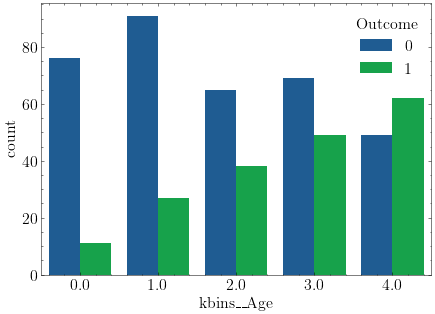

In [234]:
# Verificando a nova feature discretizada

sns.countplot(data=X_train_bins.join(y_train), x="kbins__Age", hue='Outcome');

In [235]:
correlacao(X_train_bins.join(y_train))

Outcome                                    1.000000
remainder__Glucose                         0.477387
log_transform__Insulin                     0.431625
remainder__BMI                             0.306815
kbins__Age                                 0.303735
remainder__SkinThickness                   0.284747
remainder__Pregnancies                     0.207352
remainder__BloodPressure                   0.183750
log_transform__DiabetesPedigreeFunction    0.153839
Name: Outcome, dtype: float64


A correlação melhorou.

In [236]:
validacao_cruzada(X_train_bins, y_train, log_clf, treatment=std)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8474618979882139 (std=0.03350973544404082)
Acurácia: 0.7710453444098303 (std=0.027823132606573632)
Precisão: 0.656146933938975 (std=0.02844402734648128)
Recall: 0.7173541963015648 (std=0.06964842539787815)


O tratamento é semelhante à uma condificação por faixa etária (criança, jovem, adulto, idoso). Melhoramos nosso resultado e simplificamos nosso modelo. Seguiremos com esse tratamento.

## Quantile Scaling

`BMI` parece ser uma feature importante, mas talvez precise ser ajustada e seus outliers tratados. Vamos testar um QuantileTransformer.

In [237]:
# QT

imp = KNNImputer(n_neighbors=13)
log_transform = FunctionTransformer(np.log, feature_names_out='one-to-one')
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
qt = QuantileTransformer(n_quantiles=3, random_state=42)

ct = ColumnTransformer([('log_transform', log_transform, ['Insulin', 'DiabetesPedigreeFunction']),
                        ('kbins', kbins, ['Age']),
                        ('quantile', qt, ['BMI'])
                       ], remainder='passthrough')


tr_pipeline = Pipeline([('imputer', imp), ('ct', ct)]).set_output(transform='pandas')

X_train_qt = tr_pipeline.fit_transform(X_train)

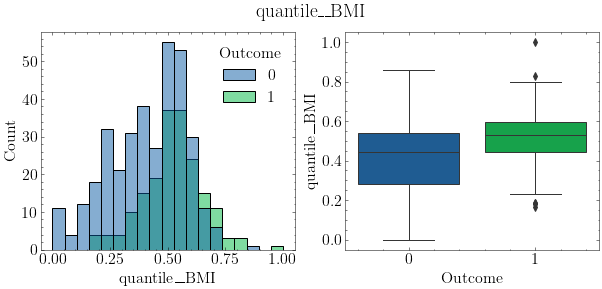

In [238]:
plot_histgram_and_boxplot(X_train_qt.join(y_train), "quantile__BMI")

In [239]:
validacao_cruzada(X_train_qt, y_train, log_clf, treatment=std)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8519203413940257 (std=0.032819764013388056)
Acurácia: 0.7802872966424369 (std=0.023722372170649476)
Precisão: 0.668492725194818 (std=0.030466056202855685)
Recall: 0.7331436699857753 (std=0.0560307148422037)


Essa transformação nos rendeu uma sutil melhora. Vamos seguir com ela.

## Final pipeline

In [240]:
imp = KNNImputer(n_neighbors=13)
log_transform = FunctionTransformer(np.log, feature_names_out='one-to-one')
kbins = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
qt = QuantileTransformer(n_quantiles=3, random_state=42)
std = StandardScaler()

ct = ColumnTransformer([('log_transform', log_transform, ['Insulin', 'DiabetesPedigreeFunction']),
                        ('kbins', kbins, ['Age']),
                        ('quantile', qt, ['BMI'])
                       ], remainder='passthrough')


final_pipeline = Pipeline([('imputer', imp), ('ct', ct), ('scaler', std)]).set_output(transform='pandas')
final_pipeline

Pipeline(steps=[('imputer', KNNImputer(n_neighbors=13)),
                ('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('log_transform',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log'>),
                                                  ['Insulin',
                                                   'DiabetesPedigreeFunction']),
                                                 ('kbins',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  ['Age']),
                                                 ('quantile',
                                                  QuantileTransformer(n_quantiles=3,
                                                                      random_state=42),
                                                  ['BMI'])])),
                ('scaler', StandardScaler())])

In [241]:
# Testando pipeline

log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})

X_train_tr = final_pipeline.fit_transform(X_train)
validacao_cruzada(X_train_tr, y_train, log_clf)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8498333672017881 (std=0.03096123876701511)
Acurácia: 0.7728452751817237 (std=0.03231440176408488)
Precisão: 0.6677777777777777 (std=0.059045912247050775)
Recall: 0.7165007112375533 (std=0.08663515708669244)


## Feature Selection

Testando se o modelo performa melhor com menos features com `SelectKBest`.

In [242]:
from sklearn.feature_selection import f_classif, SelectKBest

k_array = np.arange(1, 9)
auc_array = np.zeros(len(k_array))

for i in range(len(k_array)):
    fs = SelectKBest(score_func=f_classif, k=k_array[i]).set_output(transform='pandas')
    X_train_selected = fs.fit_transform(X_train_tr, y_train)
    print(f'k = {k_array[i]}')
    validacao_cruzada(X_train_selected, y_train, log_clf)

k = 1
Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.790619792725056 (std=0.03614021636546088)
Acurácia: 0.7448598130841122 (std=0.03573105127209197)
Precisão: 0.6504496990267093 (std=0.08580240411481839)
Recall: 0.6314366998577524 (std=0.06858690562405148)
k = 2
Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.7962446657183498 (std=0.03937974247445168)
Acurácia: 0.7262893734856352 (std=0.036270011655875393)
Precisão: 0.6133841623257161 (std=0.07351020896620059)
Recall: 0.6366998577524894 (std=0.0652874235125052)
k = 3
Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8285165616744564 (std=0.03211993659964394)
Acurácia: 0.7504672897196262 (std=0.043207213012156014)
Precisão: 0.6358156028368794 (std=0.072380969399504)
Recall: 0.6901849217638693 (std=0.055400977112734756)
k = 4
Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8419426945742735 (std=0.028501733775508457)
Acurácia: 0.7486154378677743 (std=0.0174771

O melhor resultado ainda é mantendo todas as features para o modelo.

## Modelos finais

Feito o tratamento, vamos testar como ficam os resultados nos outros modelos e fazer alguns ajustes.

### Logistic regression

In [243]:
log_clf = LogisticRegression(class_weight={0:1.0, 1:1.6})
log_clf = validacao_cruzada(X_train_tr, y_train, log_clf, return_estimator=True)

Modelo LogisticRegression(class_weight={0: 1.0, 1: 1.6})
ROC-AUC: 0.8498333672017881 (std=0.03096123876701511)
Acurácia: 0.7728452751817237 (std=0.03231440176408488)
Precisão: 0.6677777777777777 (std=0.059045912247050775)
Recall: 0.7165007112375533 (std=0.08663515708669244)


In [244]:
# Grid search para Logistic Regressiabson

params = [{'C':np.linspace(1.0, 2.0, 10), 
           'class_weight':[{0:1-x, 1:x} for x in np.linspace(0.5, 0.5, 15)]}]

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gridsearch = GridSearchCV(log_clf, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=skf, verbose=1)

gridsearch.fit(X_train_tr, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=LogisticRegression(class_weight={0: 1.0, 1: 1.6}),
             n_jobs=-1,
             param_grid=[{'C': array([1.        , 1.11111111, 1.22222222, 1.33333333, 1.44444444,
       1.55555556, 1.66666667, 1.77777778, 1.88888889, 2.        ]),
                          'class_weight': [{0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}, {0: 0.5, 1: 0.5},
                                           {0: 0.5, 1: 0.5}]}],
             scoring='roc_auc', verbose=1)

In [245]:
gridsearch.best_score_

0.8500731558626295

In [246]:
log_clf = gridsearch.best_estimator_

In [247]:
validacao_cruzada(X_train_tr, y_train, log_clf, return_estimator=True)

Modelo LogisticRegression(C=1.3333333333333333, class_weight={0: 0.5, 1: 0.5})
ROC-AUC: 0.8500731558626295 (std=0.03206551496446799)
Acurácia: 0.785964001384562 (std=0.04218889410627049)
Precisão: 0.7549206349206349 (std=0.11434125634474342)
Recall: 0.604551920341394 (std=0.09885229748441493)


LogisticRegression(C=1.3333333333333333, class_weight={0: 0.5, 1: 0.5})

## Random Forest

In [248]:
# # Randomized Search CV para a Random Forest

# forest_clf = RandomForestClassifier(class_weight='balanced', random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "min_samples_split": [2,5,10,30],
#                "max_features": [3,4,5,6,7]
#               }
# forest_randcv = RandomizedSearchCV(forest_clf, params_grid, n_iter=100, cv=5, scoring='recall', verbose=2, n_jobs=-1)
# forest_randcv.fit(X_train_tr, y_train)

In [249]:
forest_clf = RandomForestClassifier(n_estimators=300, 
                                    min_samples_leaf=3,
                                    max_depth=5,
                                    class_weight={0:1.0, 1:1.6}, 
                                    random_state=42)

forest_clf = validacao_cruzada(X_train_tr, y_train, forest_clf, return_estimator=True)

Modelo RandomForestClassifier(class_weight={0: 1.0, 1: 1.6}, max_depth=5,
                       min_samples_leaf=3, n_estimators=300, random_state=42)
ROC-AUC: 0.8414427961796382 (std=0.033577587722124456)
Acurácia: 0.7598996192454136 (std=0.04845329533247175)
Precisão: 0.6408443819426297 (std=0.06541661847656462)
Recall: 0.7173541963015648 (std=0.10154479804244931)


### XGBoost

In [250]:
# # Randomized Search CV para a XGBoost

# xgb_clf = XGBClassifier(learning_rate=0.07, max_depth=6, n_estimators=500, random_state=42)

# params_grid = {"n_estimators":np.linspace(100,1000,10, dtype=np.int), 
#                "max_depth":np.arange(4, 21, 1, dtype=np.int),
#                "learning_rate": np.linspace(0,1,11)
#               }
# xgb_randcv = RandomizedSearchCV(xgb_clf, params_grid, n_iter=100, cv=3, scoring='accuracy', verbose=3, n_jobs=-1)
# xgb_randcv.fit(X_train_tr, y_train)

# print(f'Melhor estimador:{xgb_randcv.best_params_}')
# relatorio_cross_val(xgb_randcv.best_estimator_, X_train_tr, y_train)

In [251]:
# Grid Search CV para XGB

# params = {
#     "learning_rate": [0.06, 0.09, 0.1, 0.2],
#     "max_depth":[4,5,6,7,8],
#     "n_estimators":[100,200,500]}

# grid_search_cv = GridSearchCV(xgb_clf, params, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
# grid_search_cv.fit(X_train, y_train)
# grid_search_cv.best_estimator_
# grid_search_cv.best_score_

In [252]:
# # Vamos reservar um modelo treinado para fazer um ensemble

# xgb_clf = XGBClassifier(learning_rate=0.8, 
#                         max_depth=5, 
#                         n_estimators=500,
#                         random_state=42)

# xgb_clf.fit(X_train_tr, y_train)
# relatorio_cross_val(xgb_clf, X_train_tr, y_train)

## LGBM

In [253]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=200,
                          max_depth=5,
                          class_weight={0:1.0, 1:1.6},
                          random_state=42)

lgbm_clf = validacao_cruzada(X_train_tr, y_train, lgbm_clf, return_estimator=True)

Modelo LGBMClassifier(class_weight={0: 1.0, 1: 1.6}, max_depth=5, n_estimators=200,
               random_state=42)
ROC-AUC: 0.8043263564316196 (std=0.031359797131089814)
Acurácia: 0.74312911041883 (std=0.028729069960115233)
Precisão: 0.6442653482976064 (std=0.0557924552527896)
Recall: 0.6049786628733997 (std=0.08202588952007876)


## Support-vector machine

In [254]:
svc_clf = SVC(kernel='linear', C=1.8, probability=True, class_weight={0:1.0, 1:1.6})
svc_clf = validacao_cruzada(X_train_tr, y_train, svc_clf, return_estimator=True)

Modelo SVC(C=1.8, class_weight={0: 1.0, 1: 1.6}, kernel='linear', probability=True)
ROC-AUC: 0.8463178215809795 (std=0.03128682943284599)
Acurácia: 0.770976116303219 (std=0.02954373830668642)
Precisão: 0.6725445396436828 (std=0.06789047401698725)
Recall: 0.7004267425320057 (std=0.07164164224409952)


### Majority vote 

In [255]:
estimators = [('forest', forest_clf), ('svc', svc_clf), ('log', log_clf)]
voting_soft_clf = VotingClassifier(estimators, voting='soft')

validacao_cruzada(X_train_tr, y_train, voting_soft_clf)


Modelo VotingClassifier(estimators=[('forest',
                              RandomForestClassifier(class_weight={0: 1.0,
                                                                   1: 1.6},
                                                     max_depth=5,
                                                     min_samples_leaf=3,
                                                     n_estimators=300,
                                                     random_state=42)),
                             ('svc',
                              SVC(C=1.8, class_weight={0: 1.0, 1: 1.6},
                                  kernel='linear', probability=True)),
                             ('log',
                              LogisticRegression(C=1.3333333333333333,
                                                 class_weight={0: 0.5,
                                                               1: 0.5}))],
                 voting='soft')
ROC-AUC: 0.8509164803901648 (std=0.03285015579496792)


Os modelos que se mostraram mais interessantes foram o **Logistic Regression** e o **Majority Vote**. Dado que as performaces são semelhantes, escolheriamos aqui o modelo Logistic Regression por este ser mais simples e rápido. 

Por fim, calcularemos as curvas de precisão/recall e ROC para ajustar o thrshold de classficação do modelo.

In [256]:
# Refitando com todos os dados

log_clf.fit(X_train_tr, y_train)
y_train_scores = log_clf.predict_proba(X_train_tr)

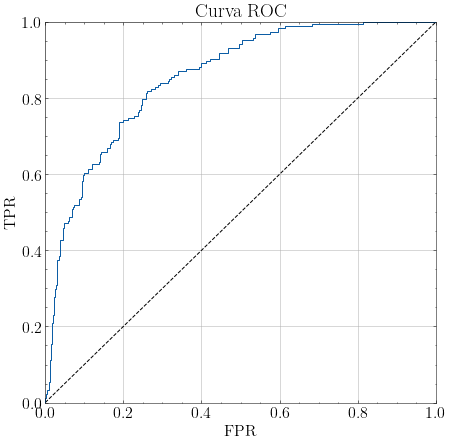

In [257]:
# ROC Curve

from sklearn.metrics import roc_curve

plt.figure(figsize=(7,7))
fpr, tpr, thr = roc_curve(y_train, y_train_scores[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.grid()
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Curva ROC')
plt.show()

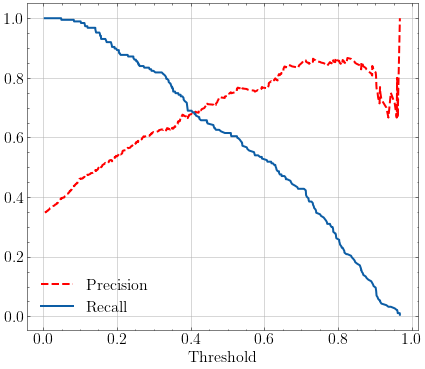

In [258]:
# Precision-recall

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_scores[:,1])

plt.figure(figsize=(7,6))
plt.plot(thresholds, precisions[:-1], lw=2, c='r', ls='--',label='Precision')
plt.plot(thresholds, recalls[:-1], lw=2, label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.grid()
plt.show()

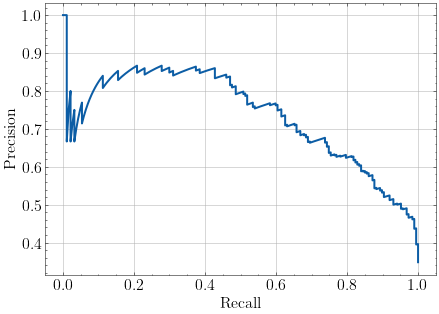

In [259]:
plt.plot(recalls, precisions, lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()

Esses gráficos permitem que façamos a escolha final do threshold do modelo e ajustar o recall para um valor desejado. Vemos que é possível escolher um modelo com 80% de recall e ainda ter uma precisão razoável. Vamos determinar esses valores.

In [260]:
def metrics_report(y_test, y_pred, y_scores):
    auc = np.round(roc_auc_score(y_test, y_scores), 4)
    accuracy = np.round(accuracy_score(y_test, y_pred), 4)
    precision = np.round(precision_score(y_test, y_pred), 4)
    recall = np.round(recall_score(y_test, y_pred), 4)
    f1 = np.round(f1_score(y_test, y_pred), 4)
    print(f"AUC score: {auc}")
    print(f"Accuracy score: {accuracy}")
    print(f"Precision score: {precision}")
    print(f"Recall score: {recall}")
    print(f"F1 score: {f1}")

In [261]:
thr = thresholds[np.argmin(recalls >= 0.8)]

y_pred_adjusted = (y_train_scores[:,1] > thr) * 1.0
metrics_report(y_train, y_pred_adjusted, y_train_scores[:,1])

AUC score: 0.8558
Accuracy score: 0.7635
Precision score: 0.6261
Recall score: 0.7968
F1 score: 0.7012


Com isso finalizamos a análise com os dados de teste. Tivemos um resultado interessante: AUC de 0.855, o recall foi ajustado para um valor próximo de 80% e nossa precisão com isso foi de aproximadamente 63%.

## Avaliação final do modelo

Finalmente vamos analisar nosso modelo com um conjunto de dados que nunca foi visto.

In [262]:
X_test.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
730,3,130.0,78.0,23.0,79.0,28.400000,0.323,34
198,4,109.0,64.0,44.0,99.0,34.799999,0.905,26
24,11,143.0,94.0,33.0,146.0,36.599998,0.254,51
417,4,144.0,82.0,32.0,NaN,38.500000,0.554,37
387,8,105.0,100.0,36.0,NaN,43.299999,0.239,45


In [263]:
# Tratamento dos dados de teste

X_test_tr = final_pipeline.transform(X_test)

In [264]:
y_scores = log_clf.predict_proba(X_test_tr)[:,1]
y_pred_adjusted = (y_scores > thr) * 1.0

metrics_report(y_test, y_pred_adjusted, y_scores)

AUC score: 0.8548
Accuracy score: 0.7835
Precision score: 0.6598
Recall score: 0.7901
F1 score: 0.7191


Os resultados de teste e treino foram próximos o suficiente para que não caracterizassemos *overfitting*. Ademais, nosso modelo apresentou resultados interessantes.

Por fim, analisaremos os top 10% de classificação do modelo, a curva de ganhos e a curva lift do modelo.

In [265]:
# Selecionando os top 10% pacientes que possívelmente são diabéticos

X_test.loc[(y_scores > np.quantile(y_scores, 0.9)),:].join(y_test)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
425,4,184.0,78.0,39.0,277.0,37.000000,0.264,31,1
185,7,194.0,68.0,28.0,NaN,35.900002,0.745,41,1
247,0,165.0,90.0,33.0,680.0,52.299999,0.427,23,0
259,11,155.0,76.0,28.0,150.0,33.299999,1.353,51,1
245,9,184.0,85.0,15.0,NaN,30.000000,1.213,49,1
424,8,151.0,78.0,32.0,210.0,42.900002,0.516,36,1
579,2,197.0,70.0,99.0,NaN,34.700001,0.575,62,1
761,9,170.0,74.0,31.0,NaN,44.000000,0.403,43,1
212,7,179.0,95.0,31.0,NaN,34.200001,0.164,60,0
215,12,151.0,70.0,40.0,271.0,41.799999,0.742,38,1


In [266]:
# Taxa do alvo (10%)

top10 = X_test.loc[(y_scores > np.quantile(y_scores, 0.9)),:].join(y_test)

top10['Outcome'].sum() / y_test.sum() 

0.2345679012345679

Esse resultado significa que, percorrendo 10% da nossa base (rankeada pela score de propensão a diabetes) coletamos 23.4% de todos os pacientes diabéticos. Podemos generalizar esse resultado, calculando o ganho por todos os percentuais da base. O resultado é a **curva de ganho**.

<Figure size 576x432 with 0 Axes>

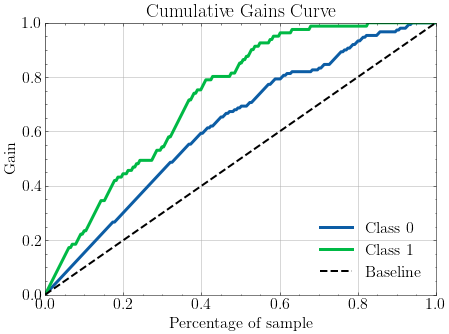

In [267]:
# Curva de ganhos cumulativos

import scikitplot as skplt

plt.figure(figsize= (8,6))
skplt.metrics.plot_cumulative_gain(y_test, log_clf.predict_proba(X_test_tr))
plt.show()

Caso estejamos interessados apenas na melhora em relação à um modelo baseline, podemos analisar a **curva de lift**.

<Figure size 576x432 with 0 Axes>

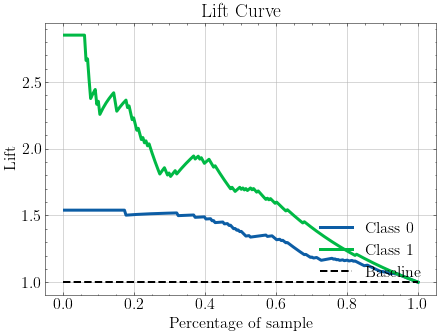

In [268]:
# Curva de lift

plt.figure(figsize= (8,6))
skplt.metrics.plot_lift_curve(y_test, log_clf.predict_proba(X_test_tr))
plt.show()

De fato, nosso modelo performa melhor que um modelo aleatório por um fator de aproximadamente 2.5 quando temos amostras entre 10% - 20%.

# Conclusões

Finalmente vamos consolidar os resultados. Uma métrica importante foi bastante melhor: o recall. Além disso, ganhamos um pouco de acurácia, ao custo de uma pequena redução da precisão. Do ponto de vista de saúde pública isso é interessante: queremos alcançar todos os possíveis diabéticos, ainda que reduzindo um pouco a precisão. Outra métrica que demonstra que nosso modelo é mais equilibrado é a F1: modelos com recall e precisão semelhantes tem melhor resultado. 

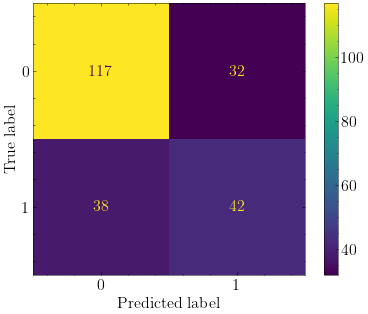

In [269]:
# Matriz de confusão do modelo heurístico

ConfusionMatrixDisplay(cm_heuristic).plot();

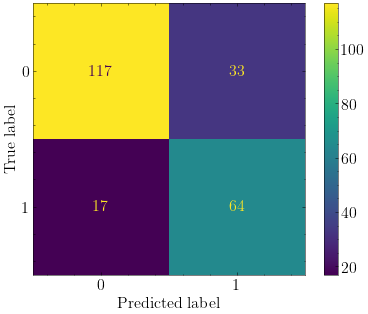

In [270]:
# Matriz de confusão do nosso modelo com ML
cm_ml = confusion_matrix(y_test, y_pred_adjusted)
ConfusionMatrixDisplay(cm_ml).plot();

In [271]:
# Redução percentual de falsos negativos em relação ao modelo heurístico

100 * cm_ml[1,0] / cm_heuristic[1,0] 

44.73684210526316

Atingimos nosso objetivo de reduzir o número de falsos negativos em torno de 45%! 

Vamos considerar um cenário de custos dos erros. Tomemos como base que um falso negativo gere um custo três vezes maior que um falso positivo. Isso é razoável já que um falso negativo acarreta em maiores custos devido a um tratamento tardio à um paciente diabético, enquanto um falso positivo só implica que aplicamos um tratamento preventivo a um paciente que possivelmente não seria diabético. Vamos avaliar nosso modelo em comparação ao heurístico.

In [272]:
# Falsos negativos tem três vezes mais impacto que um falso positivo

cost_matrix = np.array([[0, 1],
                        [3, 0]])

ml_cost = cost_matrix * cm_ml
heuristic_cost = cost_matrix * cm_heuristic

ml_cost_sum = ml_cost.sum()
heuristic_cost_sum = heuristic_cost.sum()

print(f'Fator percentual de redução de custos: {100*(1 - ml_cost_sum / heuristic_cost_sum):.3f}')

Fator percentual de redução de custos: 42.466


Nesses moldes, temos então uma redução de custos de 42% por paciente devido à erros de classificação.

# Deploy

In [273]:
# Criar uma pipeline para o deploy unindo o tratamento e a previsão

model_pipeline = Pipeline([('treatment', final_pipeline), ('svm', log_clf)])
model_pipeline

Pipeline(steps=[('treatment',
                 Pipeline(steps=[('imputer', KNNImputer(n_neighbors=13)),
                                 ('ct',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('log_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'log'>),
                                                                   ['Insulin',
                                                                    'DiabetesPedigreeFunction']),
                                                                  ('kbins',
                                                                   KBinsDiscretizer(encode='ordinal'),
                                                                   ['Age']),
                                                                  ('quantile',
                                                                   QuantileTransformer(n_quantiles=3,
                                                                                       random_state=42),
                                                                   ['BMI'])])),
                                 ('scaler', StandardScaler())])),
                ('svm',
                 LogisticRegression(C=1.3333333333333333,
                                    class_weight={0: 0.5, 1: 0.5}))])

In [274]:
# Fazendo o dump

import joblib
import os

joblib.dump(model_pipeline, '../model/model.pkl')

['../model/model.pkl']

In [275]:
# Testando

load_model = joblib.load("../model/model.pkl")
load_model.predict_proba(pd.DataFrame(X_test.iloc[3]).T)

array([[0.29118879, 0.70881121]])